In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# -------------------- 1. Imports --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -------------------- 2. Reprodutibilidade --------------------
tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

# -------------------- 3. Carregar Dataset --------------------
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";", na_values="?", low_memory=False)

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df[["Datetime", "Global_active_power", "Global_reactive_power", "Voltage",
         "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].dropna()

df = df.set_index("Datetime").resample("H").mean().dropna()

# -------------------- 4. Normalização --------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

#test local change
# -------------------- 5. Função para Janelas de 7 dias --------------------
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # prever só Global_active_power
    return np.array(X), np.array(y)

window_size = 168  # 7 dias (24h x 7)
X, y = create_sequences(scaled_data, window_size)

# -------------------- 6. Dividir Treino/Teste --------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------- 7. Construir Modelo --------------------
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# -------------------- 8. EarlyStopping --------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# -------------------- 9. Treinar --------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# # -------------------- 10. Previsão --------------------
# y_pred = model.predict(X_test)

# # Desnormalizar apenas a coluna alvo
# y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), X.shape[2]-1))], axis=1))[:, 0]
# y_pred_inv = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), X.shape[2]-1))], axis=1))[:, 0]

# # -------------------- 11. Avaliação --------------------
# mae = mean_absolute_error(y_test_inv, y_pred_inv)
# rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
# r2 = r2_score(y_test_inv, y_pred_inv)

# print("MAE:", mae)
# print("RMSE:", rmse)
# print("R²:", r2)

# # -------------------- 12. Curva de Loss --------------------
# plt.plot(history.history["loss"], label="Treino")
# plt.plot(history.history["val_loss"], label="Validação")
# plt.title("Curva de Loss - LSTM Otimizado (7 dias, múltiplas variáveis)")
# plt.xlabel("Épocas")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)
# plt.show()


<ipython-input-1-3648191194>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("Datetime").resample("H").mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0182 - val_loss: 0.0105
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 12/50
500/500 ━━━━━━━━━━━━━

TypeError: got an unexpected keyword argument 'squared'

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MAE: 0.31738738620700724
RMSE: 0.21237972742736153
R²: 0.5967567781531335


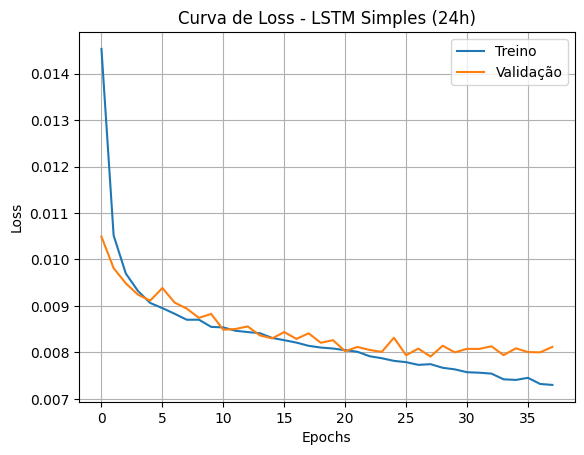

In [ ]:
# -------------------- 10. Avaliação --------------------
y_pred = model.predict(X_test)
# y_test e y_pred têm shape (amostras, 24, 1)

def invert_scale(y_scaled, n_features):
    inv = []
    for yseq in y_scaled:
        yseq = yseq.reshape(-1, 1)  # garante shape (24, 1)
        extended = np.concatenate([yseq, np.zeros((yseq.shape[0], n_features - 1))], axis=1)
        inv_seq = scaler.inverse_transform(extended)[:, 0]  # pega só Global_active_power
        inv.append(inv_seq)
    return np.array(inv)

# Aplicar
y_test_inv = invert_scale(y_test, X.shape[2])
y_pred_inv = invert_scale(y_pred, X.shape[2])


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = mean_squared_error(y_test_inv, y_pred_inv,)
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# -------------------- 11. Plot da Curva de Loss --------------------
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Curva de Loss - LSTM Simples (24h)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


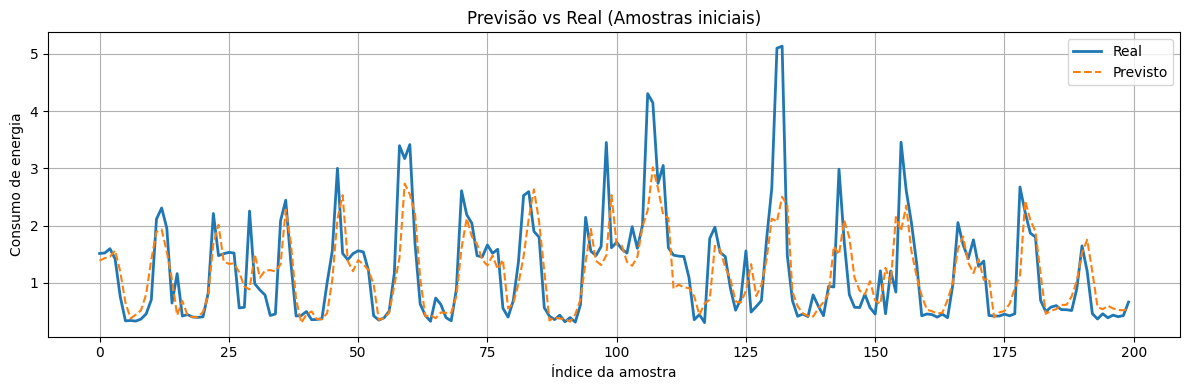

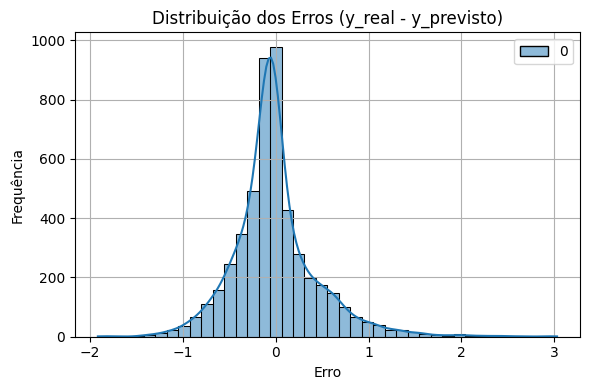

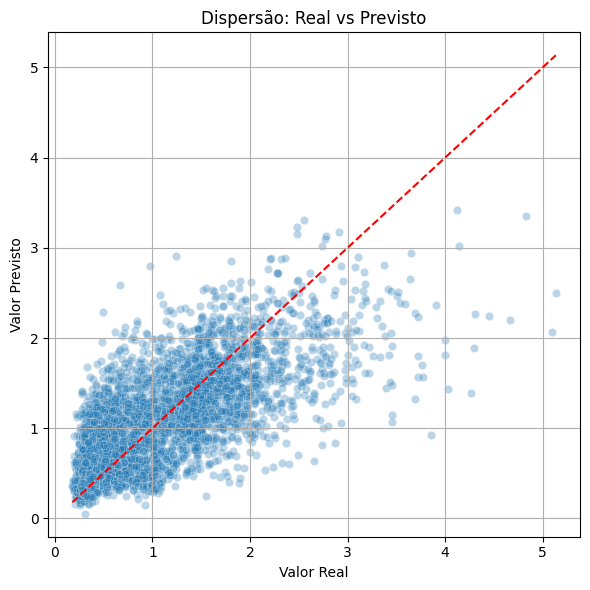

In [ ]:
import seaborn as sns

# Gráfico 1: Curva de previsão (real vs previsto)
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:200], label='Real', linewidth=2)
plt.plot(y_pred_inv[:200], label='Previsto', linestyle='--')
plt.title('Previsão vs Real (Amostras iniciais)')
plt.xlabel('Índice da amostra')
plt.ylabel('Consumo de energia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Histograma dos erros
errors = y_test_inv - y_pred_inv
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=40, color='gray')
plt.title('Distribuição dos Erros (y_real - y_previsto)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Dispersão entre real e previsto
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred_inv.flatten(), alpha=0.3)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # linha ideal
plt.title('Dispersão: Real vs Previsto')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.grid(True)
plt.tight_layout()
plt.show()